In [1]:
!test -f tz_1000.grib || wget https://get.ecmwf.int/repository/test-data/fieldlist/examples/tz_1000.grib

### Use case: interpolate, compute and plot mean from GRIB file input

Demonstrates the following workflow with the available earthkit components:
- read GRIB data with multiple parameters from a file
- filter temperature on a pressure level
- interpolate it onto another (lat-lon) grid and area
- compute the mean as an ndarray
- generate a plot for the mean

All of it is done by using an iteration and keeping only one GRIB field in memory at a time. No data is written to disk.

In [2]:
import io
import matplotlib.pyplot as plt
import numpy as np
import mir
import emohawk

fs = emohawk.load_from("file", "tz_1000.grib")

In [3]:
# define the interpolation job
job = mir.Job(grid='0.2/0.2', area='70/-30/20/70')

In [4]:
res = None
num = 0

# note: sel() first iterates through the messages and returns a
# view to the ones matching the conditions
for f in fs.sel(param="t", level=1000):
    # interpolate - the input is a GRIB message in memory,
    # the output is a GRIB message in memory stored in buf
    data = f.message()
    mem_out = io.BytesIO()
    job.execute(mir.GribMemoryInput(data), mem_out)
   
    # load the resulting GRIB message into emohawk
    g = emohawk.load_from("memory", mem_out.getvalue())[0]
    
    if res is None:
        # start accumulation
        res = g.to_numpy()
        
        # get metadata for plotting
        lat, lon = g.metadata(["latitudes", "longitudes"])
    else:
        # accumulation
        res += g.to_numpy()
        
    num += 1

Compute mean.

In [5]:
res /= num  
print(f"num={num}")
print(res)

num=4
[265.83085632 265.98246765 266.07963562 ... 296.06132507 296.15116882
 296.2429657 ]


Scale result for plotting.

In [6]:
res -= 273.16

Generates a plot.

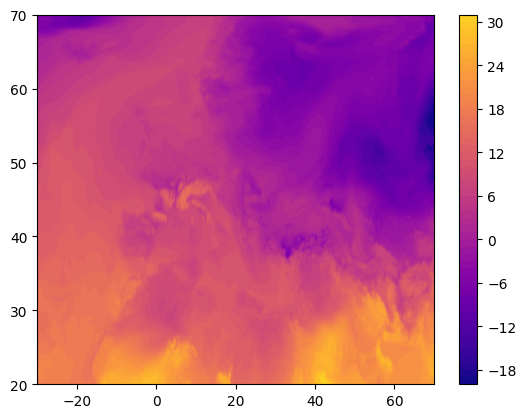

In [7]:
fig, ax = plt.subplots()
tcf = ax.tricontourf(lon, lat, res, vmin=-20, vmax=36, levels=56, cmap="plasma")
fig.colorbar(tcf)
plt.show()